# Autoencoders

<img src="../assets/architecture.png">

An Autoencoder consists of an encoder and a decoder hand-in-hand.

The encoder encodes the input, $x$ to a compressed latent representation $z$ which the decoder maps back to the input, $x$.

# Setup

## Imports

PyTorch

In [1]:
import torch

from torch import nn, optim
from torch.nn import functional as F

from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

MagNet

In [2]:
import magnet as mag

from magnet.utils.images import show_images

## HyperParameters

In [3]:
frac_valid = 0.2 # Fraction of training set held out for validation
batch_size = 64
latent_size = 32 # This is the dimensionality the images will be compressed to (from 784)
learning_rate = 3e-3

## Other setup

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
mean = lambda x: sum(x) / len(x)

loopy() takes in a Python iterator and returns an infinite version

In [9]:
def loopy(gen):
    def inf_gen():
        while True:
            for x in gen: yield x
    return inf_gen()

Returns ```DataLoaders``` for a dataset with ```frac_valid``` as the validation fraction and ```batch_size```

In [10]:
def get_dataloaders(dataset, frac_valid, batch_size):
    num_train = int((1 - frac_valid) * len(dataset))
    train_idx = range(num_train)
    valid_idx = range(num_train, len(dataset))
    
    make_dl = lambda idx: DataLoader(dataset, batch_size, sampler=SubsetRandomSampler(idx))
    
    return make_dl(train_idx), make_dl(valid_idx)

Utility function to plot the MNIST images

In [12]:
def show_mnist(x):
    show_images(x.permute(0, 2, 3, 1).cpu().numpy(), cmap='gray', pixel_range=(-1, 1))

A Context Manager that makes it easy to run statements in eval mode.

It sets ```modules``` in eval() mode and ensures that gradients are not computed

## Load Data

In [13]:
# Convert data to a Tensor object and normalize to [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*[[0.5] * 3] * 2)])

dataset = MNIST(DIR_DATA, transform=transform, download=True)

In [14]:
data, data_valid = get_dataloaders(dataset, frac_valid, batch_size)

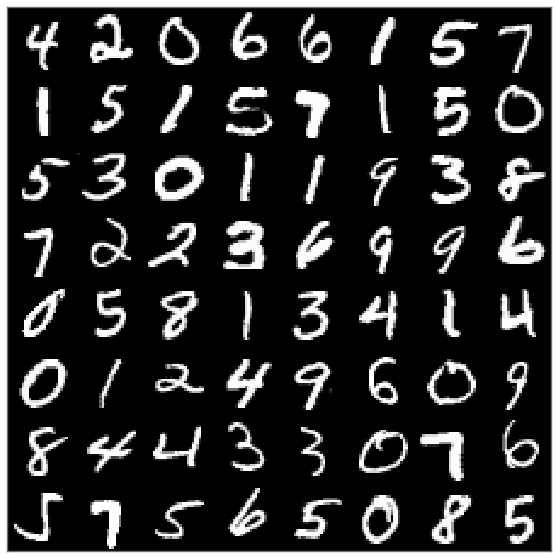

In [20]:
show_mnist(next(iter(data))[0])

# Define Training

Utility function to get loss and append to ```append_list```

Gets data from ```iterator``` and uses ```model``` to autoencode

In [22]:
def get_loss(model, iterator, append_list=None, train=True):
    # If not training, grads can be disabled and the model placed in eval() mode
    if not train:
        with mag.eval(model): return get_loss(model, iterator, append_list)
    
    x = next(iterator)[0].to(device)
    x_gen = model(x)
    loss = F.mse_loss(x_gen, x)
    
    if append_list is not None: append_list.append(loss.item())
        
    return loss

Main optimization loop

In [23]:
def optimize(model, optimizer, history, epochs=2):
    iterations = int(len(data) * epochs)
        
    model.train() # Very important if we have modules like BatchNorm and Dropout
    
    # Create infinite iterators
    data_iter = loopy(data)
    data_valid_iter = loopy(data_valid)
    
    running_loss = [] # Buffer that keeps the last epoch's losses. Averaged over.
    
    for batch in tqdm(range(iterations)):
        loss = get_loss(model, data_iter, running_loss)
                
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if len(running_loss) > len(data): running_loss.pop(0) # Maximum buffer size is one epoch
        
        # Append to history every 100 batches
        if not batch % 100:
            history['loss'].append(mean(running_loss))
            get_loss(model, data_iter, history['val_loss'], train=False)

Plots the training history from a dictionary object

In [24]:
def plot_history(history):
    plot(history['loss'], label='loss')
    plot(history['val_loss'], label='val_loss')
    
    plt.yscale('log') # Losses are better explained (and visualized) in semi-log scale
    plt.legend()
    plt.title(f"Last losses: {history['loss'][-1]:.2f}, {history['val_loss'][-1]:.2f}")
    plt.show()

Shows the reconstruction on random validation samples

In [25]:
def show_reconstruction(model):
    x = next(loopy(data_valid))[0][:5].to(device) # Get 5 sample MNIST digits
    
    # Get the latent representation and the reconstruction
    with mag.eval(model):
        z = model.encoder(x)
        x_re = F.tanh(model.decoder(z))
    x_re = x_re.view(x_re.size(0), 1, 28, 28)
    
    # Reshape z to rectangular images for easy visualization
    h = [i for i in range(int(np.sqrt(batch_size)), 1, -1) if not batch_size % i][0]
    w = z.size(1) // h
    z = z.view(z.size(0), h, w)
    
    show_mnist(x)
    show_images(z.unsqueeze(-1).cpu().numpy(), cmap='seismic', pixel_range='auto')
    show_mnist(x_re)

# Try Different Models

## Naive Linear Regression

Since the aim is to learn the identity function,

why not start with naive, unassuming **linear regression**?

In [26]:
class Linear(nn.Linear):
    def __init__(self):
        super().__init__(784, 784, bias=False)
        
    def forward(self, x):
        return super().forward(x.view(x.size(0), -1)).view(x.size(0), 1, 28, 28)

In [27]:
model = Linear().to(device)
optimizer = optim.Adam(model.parameters(), learning_rate)
history = {'loss': [], 'val_loss': []}

In [29]:
def show_linear_weights(model):
    show_images([model.weight.data.cpu().numpy()], cmap='gray', pixel_range='auto')

The weight matrix is initially just static hum

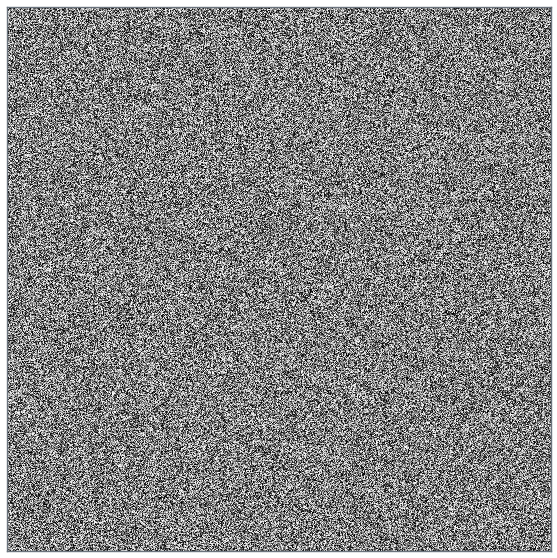

In [30]:
show_linear_weights(model)

We train the model for 2 epochs

In [31]:
optimize(model, optimizer, history, epochs=2)

/Users/Vaisakh/anaconda3/envs/autoencoder/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


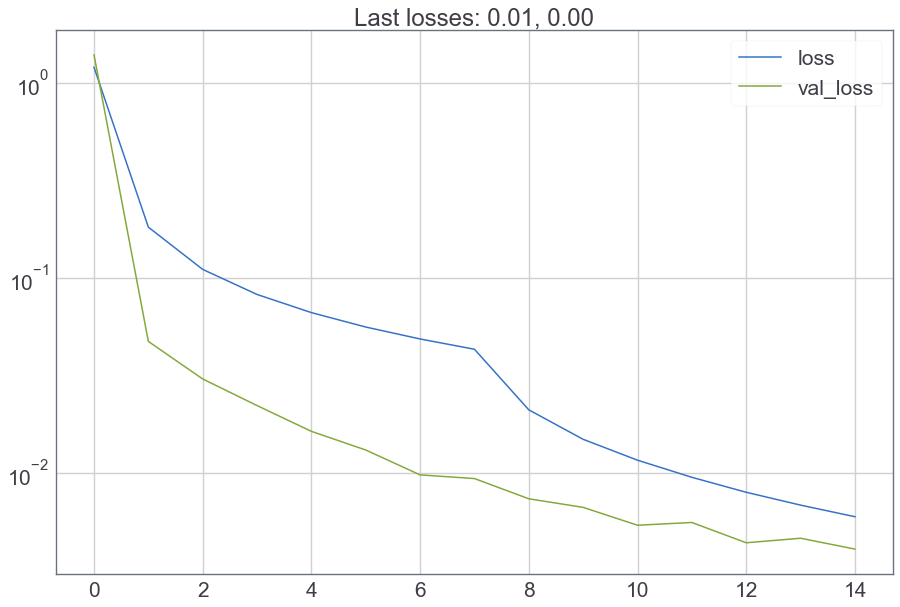

In [32]:
plot_history(history)

As expected, the diagonal is close to 1 and everything else is 0...

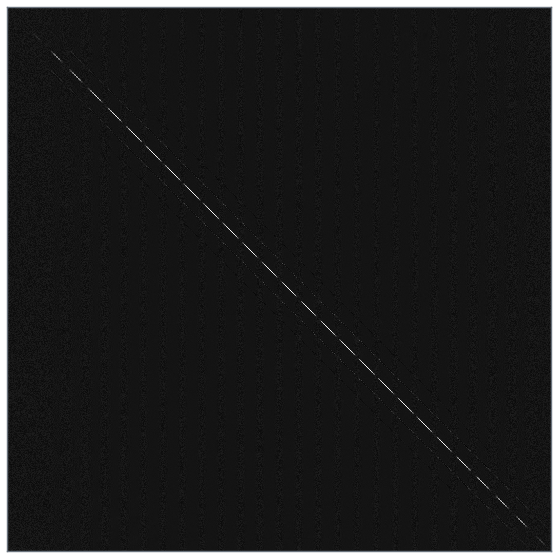

In [33]:
show_linear_weights(model)

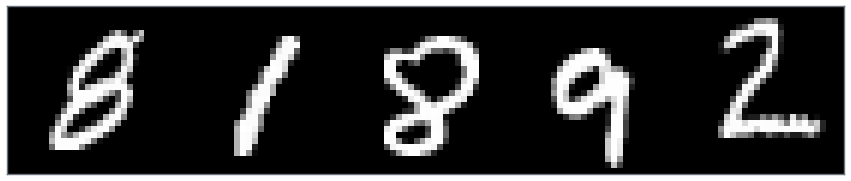

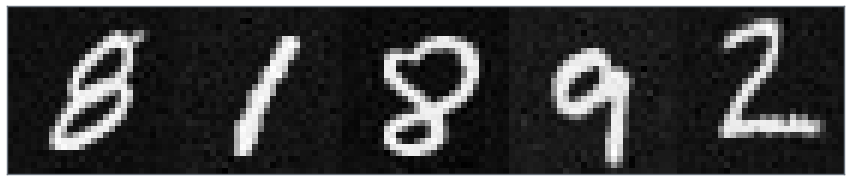

In [34]:
x = next(iter(data_valid))[0][:5].to(device)
with mag.eval(model): x_re = model(x)

show_mnist(x)
show_mnist(x_re)

But of course, this is of no practical use.

One could as well have written the identity matrix by hand!

## Real Autoencoders

Define Autoencoder Class

In [35]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        in_shape = x.shape
        z = self.encoder(x)
        x_re = F.tanh(self.decoder(z))
        
        x_re = x_re.view(in_shape) # Inflate (if necessary) back to the input shape
        return x_re

### Neural Net

This will give us a basic, vanilla feedforward neural network.

The ```sizes``` parameter specifies the layer sizes.

In [36]:
class NN(nn.Module):
    def __init__(self, *sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(sizes[i], sizes[i + 1])
                                    for i in range(len(sizes) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers[:-1]: x = F.relu(layer(x))
        return self.layers[-1](x)

#### One Hidden Layer

In [37]:
model = Autoencoder(NN(784, latent_size), NN(latent_size, 784)).to(device)

In [38]:
optimizer = optim.Adam(model.parameters(), learning_rate)
history = {'loss': [], 'val_loss': []}
optimize(model, optimizer, history, epochs=2)

/Users/Vaisakh/anaconda3/envs/autoencoder/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


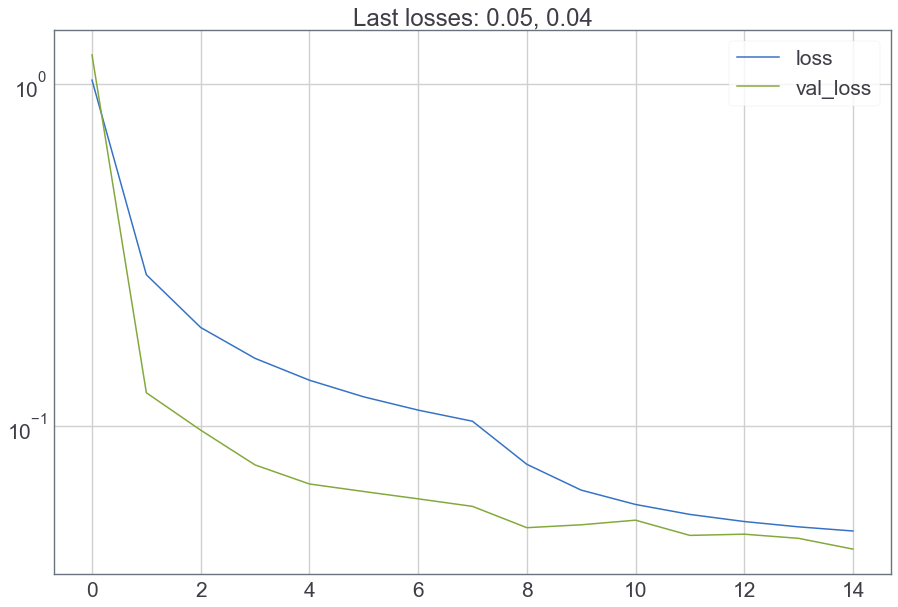

In [39]:
plot_history(history)

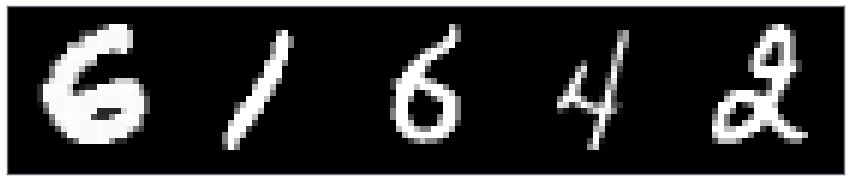

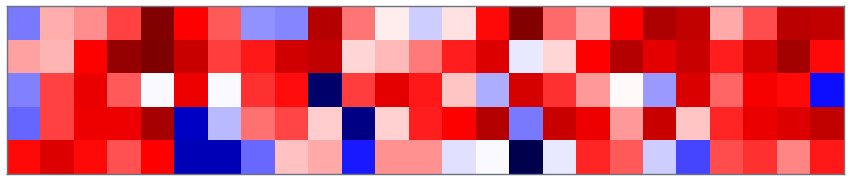

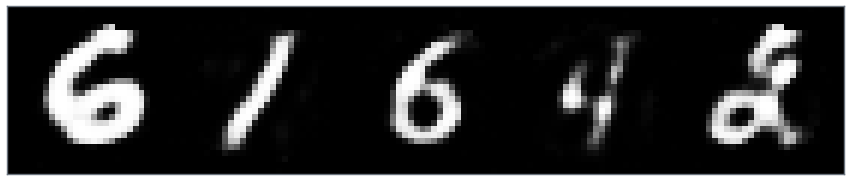

In [40]:
show_reconstruction(model)

#### 3 Hidden Layers

Let's use a 3 layer network in the hope that it will decrease the reconstruction error

In [41]:
model = Autoencoder(NN(784, 2 * latent_size, latent_size),
                    NN(latent_size, 2 * latent_size, 784)).to(device)

In [42]:
optimizer = optim.Adam(model.parameters(), learning_rate)
history = {'loss': [], 'val_loss': []}
optimize(model, optimizer, history, epochs=2)

/Users/Vaisakh/anaconda3/envs/autoencoder/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


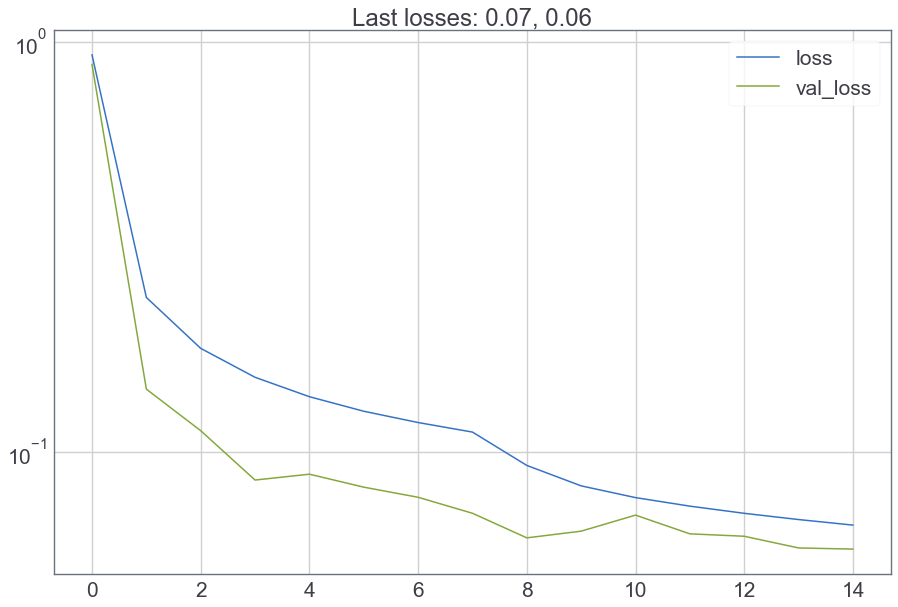

In [43]:
plot_history(history)

Unfortunately, the additional parameters and depth didn't produce any improvements.


So much for _deep_ learning.

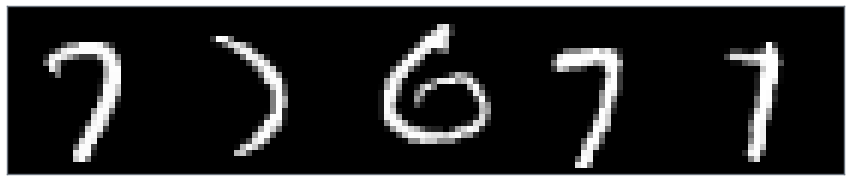

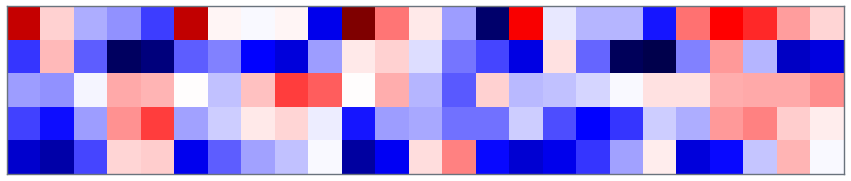

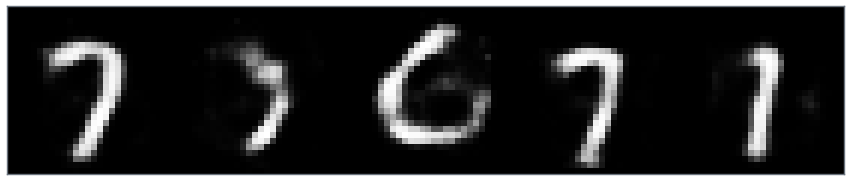

In [44]:
show_reconstruction(model)

### Convolutional Network

Since we are dealing with images, the best option right now would be to use a convolutional network

The encoder is just a two layer ConvNet that reduces the image to $7 \times 7$ images with ```latent_size``` number of channels.

Finally, we flatten this into a linear layer with ```latent_size``` units.

In [45]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, latent_size // 2, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(latent_size // 2, latent_size, 3, stride=2, padding=1)
        self.fc = nn.Linear(latent_size * 7 * 7, latent_size)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        return self.fc(x.view(x.size(0), -1))

The decoder has an almost inverse architecture, as expected.

We first map the latent vector back to $7 \times 7$ images with ```latent_size``` channels using a linear layer.

Then, we successively upsample the images using nearest-neighbor and then convolve it.
This achives the desired purpose of _deconvolution_ while avoiding checkerboard-artifacts.[1]

In [46]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_size, latent_size * 7 * 7)
        self.conv1 = nn.Conv2d(latent_size, latent_size // 2, 3, padding=1)
        self.conv2 = nn.Conv2d(latent_size // 2, 1, 3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.fc(x)).view(x.size(0), latent_size, 7, 7)
        x = F.relu(self.conv1(F.upsample(x, scale_factor=2)))
        
        return self.conv2(F.upsample(x, scale_factor=2))

In [47]:
model = Autoencoder(Encoder(), Decoder())

In [48]:
optimizer = optim.Adam(model.parameters(), learning_rate)
history = {'loss': [], 'val_loss': []}
optimize(model, optimizer, history, epochs=2)

/Users/Vaisakh/anaconda3/envs/autoencoder/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


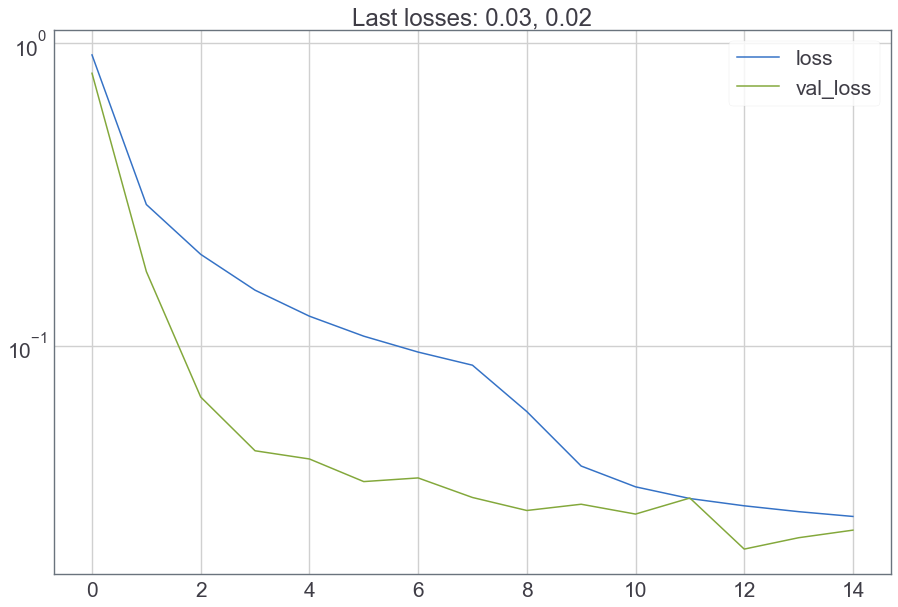

In [49]:
plot_history(history)

As expected, convolution rules!

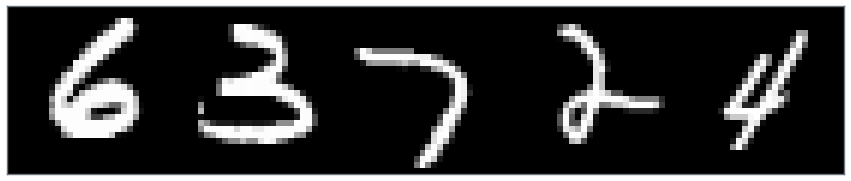

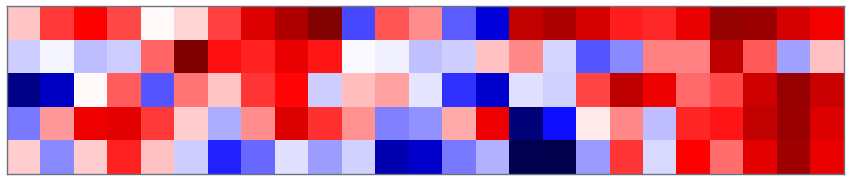

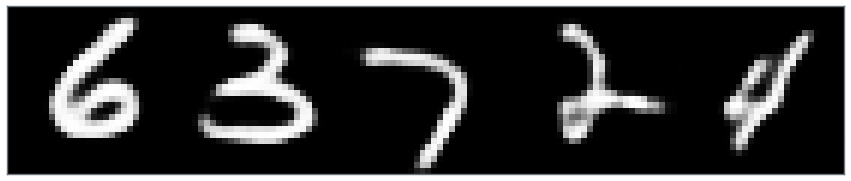

In [50]:
show_reconstruction(model)

# Latent Space

Let's see if we can fiddle with this latent representation

## Interpolation

Gets a random validation image and changes the latent code.

Produces copies with latent vector changed along a random direction.

In [51]:
@mag.eval(model)
def interpolate_latent():
    direction = torch.randn(latent_size)
    
    # Get latent vector of a random validation image
    x = next(iter(data_valid))[0][:1].to(device)
    z = model.encoder(x)
    
    # Create copies along the random direction
    zs = torch.linspace(-32, 32, 64).unsqueeze(-1) * direction.unsqueeze(0) * 0.1 + z
    
    # Get decoded images with the new latent vectors
    x_re = F.tanh(model.decoder(zs))
    x_re = x_re.view(x_re.size(0), 1, 28, 28)
    
    show_mnist(x_re)

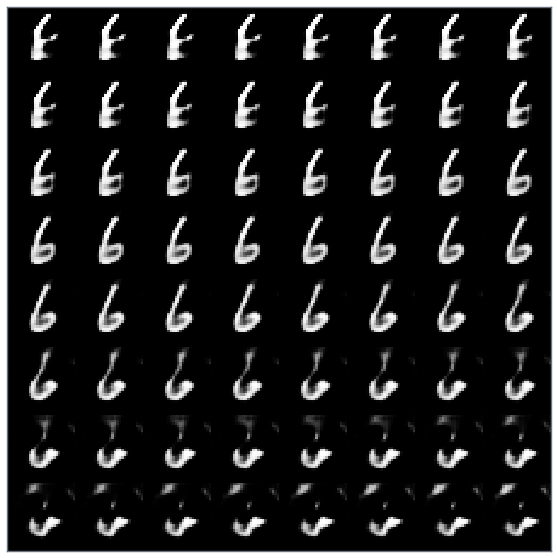

In [52]:
interpolate_latent()

<img src="../Output/latent.gif" width="600">

Changing the latent vectors does not seem to change the images in _meaningful_ ways.

## Generate Images

Let's see if we can take this further and **generate** images with the decoder.

We pass in a random normal vector to the decoder and see what it spits out

In [53]:
@mag.eval(model)
def generate():
    z = torch.randn(25, latent_size).to(device)
    x_re = F.tanh(model.decoder(z))
    show_mnist(x_re)

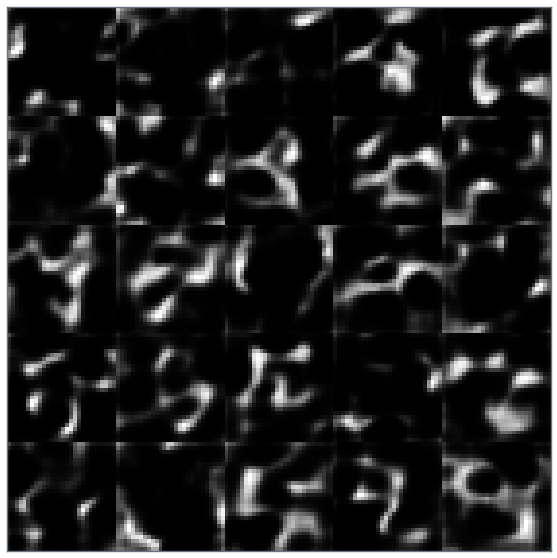

In [54]:
generate()

Dissapointingly, this is garbage.

The learned latent space manifold seems to be very different to what we want.

That is to say, there's not too many point within the random normal distribution that can give rise to real images.

Evidently, we'll need to impose some restriction on the latent space.

This is exactly what the Variational Autoencoder does!